***1.1.*** **Extracting time series data**  <br>

In [69]:
import pandas as pd
import requests
import time

In [32]:
API_KEY = 'f5920c1fc41f69f383d4e0d2a6a4a20e172016b82905ecdb4b9746c4e5b8c4c9' 

headers = {
    'authorization': f'Apikey {API_KEY}'
}

base_url = 'https://min-api.cryptocompare.com/data/v2/histoday'


In [40]:
def get_crypto_data(symbol, limit=200, to_symbol='USD'):
    params = {
        'fsym': symbol,
        'tsym': to_symbol,
        'limit': limit
    }
    
    response = requests.get(base_url, headers=headers, params=params)
    data = response.json()
    
    if data['Response'] != 'Success':
        raise ValueError(f"API call failed: {data.get('Message', 'Unknown error')}")
    
    df = pd.json_normalize(data['Data']['Data'])
    
    # Convert UNIX timestamp to datetime
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    
    # Keep only useful columns
    return df[['high', 'low', 'open', 'close', 'volumeto']]


In [41]:
ltc_df = get_crypto_data('LTC')
bsv_df = get_crypto_data('BSV')

In [42]:
combined_df = pd.concat([ltc_df['close'], bsv_df['close']], axis=1, keys=['ETH', 'BSV']).dropna()

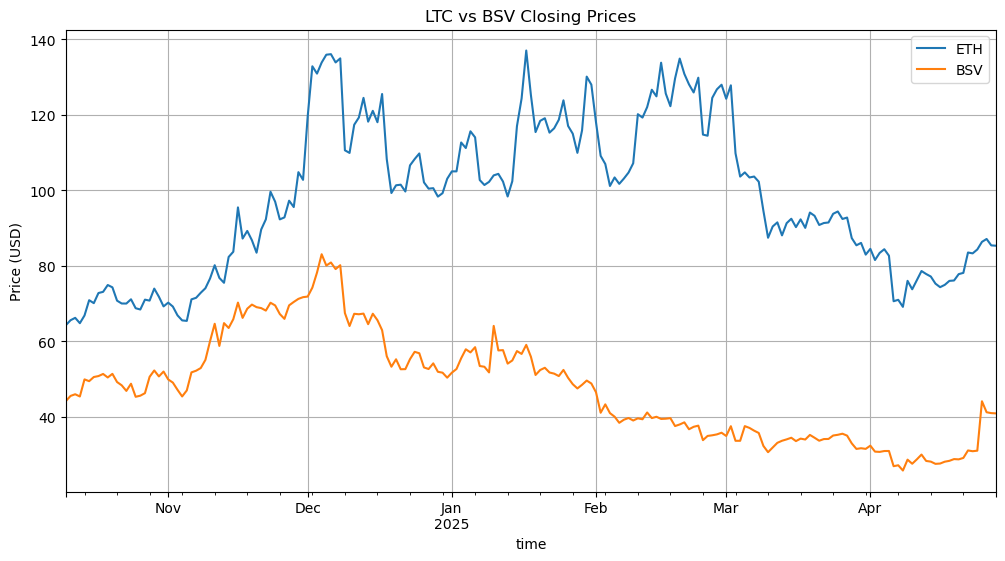

In [43]:
import matplotlib.pyplot as plt

combined_df.plot(title='LTC vs BSV Closing Prices', figsize=(12,6))
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

In [31]:
xt = combined_df['BSV'].values
yt = combined_df['ETH'].values

***1.2.*** **OLS Estimates** <br>

In [44]:
x_mean = xt.mean()
y_mean = yt.mean()

In [45]:
numerator = ((xt - x_mean) * (yt - y_mean)).sum()
denominator = ((xt - x_mean) ** 2).sum()
beta = numerator / denominator

In [46]:
alpha = y_mean - beta * x_mean

In [47]:
print(f"Alpha (α): {alpha:.4f}")
print(f"Beta (β): {beta:.4f}")

Alpha (α): 591.0194
Beta (β): 45.0853


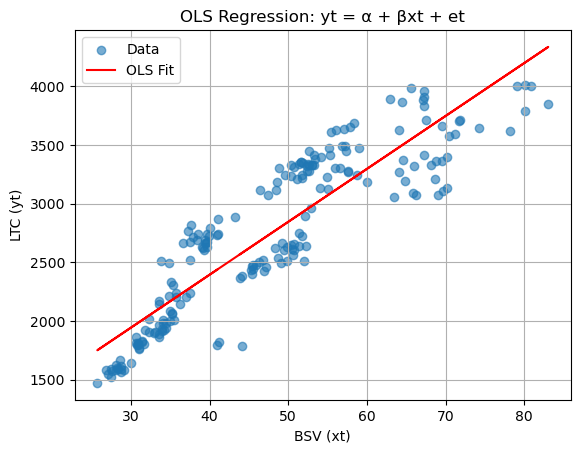

In [48]:
import matplotlib.pyplot as plt

plt.scatter(xt, yt, label='Data', alpha=0.6)
plt.plot(xt, alpha + beta * xt, color='red', label='OLS Fit')
plt.xlabel('BSV (xt)')
plt.ylabel('LTC (yt)')
plt.title('OLS Regression: yt = α + βxt + et')
plt.legend()
plt.grid(True)
plt.show()


***1.3.*** **Gradient Descent**<br>

In [57]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Scale the input data 
scaler_x = StandardScaler()
scaler_y = StandardScaler()

xt_s = scaler_x.fit_transform(xt.reshape(-1, 1)).flatten()
yt_s = scaler_y.fit_transform(yt.reshape(-1, 1)).flatten()

# Initialize parameters
alpha = 0
beta = 0

# Learning rate and iterations
lr = 0.01 
n_iterations = 5000

# Store loss values
loss_history = []

n = len(xt_s)

# Gradient Descent Loop
for i in range(n_iterations):
    y_pred = alpha + beta * xt_s
    error = yt_s - y_pred

    # Gradients
    d_alpha = -2 * error.sum() / n
    d_beta = -2 * (xt_s * error).sum() / n

    # Update parameters
    alpha -= lr * d_alpha
    beta -= lr * d_beta

    # Store loss
    loss = (error ** 2).mean()
    loss_history.append(loss)

    if i % 500 == 0:
        print(f"Iteration {i}: Loss={loss:.6f}, alpha={alpha:.4f}, beta={beta:.4f}")

print(f"\nFinal Parameters:\nAlpha (α): {alpha:.4f}\nBeta (β): {beta:.4f}")


Iteration 0: Loss=1.000000, alpha=0.0000, beta=0.0179
Iteration 500: Loss=0.198373, alpha=-0.0000, beta=0.8953
Iteration 1000: Loss=0.198373, alpha=-0.0000, beta=0.8953
Iteration 1500: Loss=0.198373, alpha=-0.0000, beta=0.8953
Iteration 2000: Loss=0.198373, alpha=-0.0000, beta=0.8953
Iteration 2500: Loss=0.198373, alpha=-0.0000, beta=0.8953
Iteration 3000: Loss=0.198373, alpha=-0.0000, beta=0.8953
Iteration 3500: Loss=0.198373, alpha=-0.0000, beta=0.8953
Iteration 4000: Loss=0.198373, alpha=-0.0000, beta=0.8953
Iteration 4500: Loss=0.198373, alpha=-0.0000, beta=0.8953

Final Parameters:
Alpha (α): -0.0000
Beta (β): 0.8953


In [66]:
print(f"\nFinal Parameters (scaled):")
print(f"Alpha (α): {alpha:.4f}")
print(f"Beta (β): {beta:.4f}")



Final Parameters (scaled):
Alpha (α): -0.0000
Beta (β): 0.8953


In [61]:
# Unscale beta and alpha back to original data scale
beta_unscaled = beta * (scaler_y.scale_[0] / scaler_x.scale_[0])
alpha_unscaled = scaler_y.mean_[0] - beta_unscaled * scaler_x.mean_[0]

In [67]:
print(f"\nFinal Parameters (unscaled):")
print(f"Alpha (α): {alpha_unscaled:.4f}")
print(f"Beta (β): {beta_unscaled:.4f}")


Final Parameters (unscaled):
Alpha (α): 591.0194
Beta (β): 45.0853


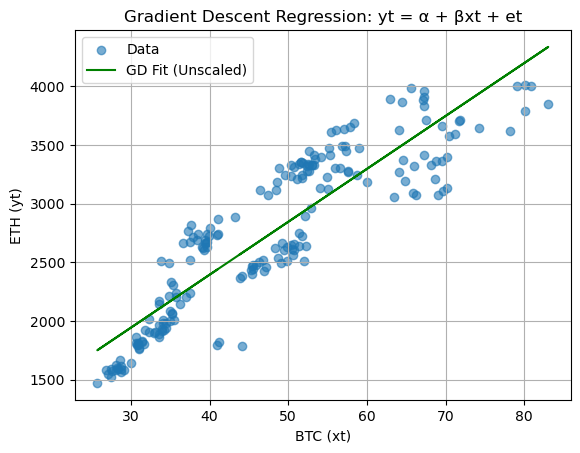

In [68]:
import matplotlib.pyplot as plt

plt.scatter(xt, yt, label='Data', alpha=0.6)
plt.plot(xt, alpha_unscaled + beta_unscaled * xt, color='green', label='GD Fit (Unscaled)')
plt.xlabel('BTC (xt)')
plt.ylabel('ETH (yt)')
plt.title('Gradient Descent Regression: yt = α + βxt + et')
plt.legend()
plt.grid(True)
plt.show()


***1.5.*** **Challenges obtaining convergence**<br>

There are several challenges that can arise when attempting to achieve convergence using gradient descent. One of the key issues I encountered was poor feature scaling. Large price magnitudes caused the gradient updates to become unstable or even explode. I first experienced this problem when running gradient descent on unscaled data, which led to divergence and failure to converge towards the Ordinary Least Squares (OLS) estimates. Proper standardisation, using tools such as StandardScaler, proved essential for ensuring stable and efficient learning.

Another significant challenge was selecting an appropriate learning rate. In my initial attempts, a learning rate that was too high caused the algorithm to overshoot the minimum, while a rate that was too low resulted in extremely slow convergence. Careful tuning of this parameter was critical for achieving stable progress.

In addition, the inherent noise and volatility in cryptocurrency price data can distort the gradient direction, often requiring more iterations to average out these fluctuations effectively. These challenges highlight the importance of understanding the characteristics of the data and carefully configuring the optimisation process to ensure successful model fitting.